In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# _generated_images 폴더 밑에 MNIST_AE 라는 폴더를 만든다
save_path = '/content/gdrive/MyDrive/pytest_img/_generated_images'
if not os.path.exists(os.path.join(save_path, 'MNIST_AE/')):
  os.makedirs(os.path.join(save_path, "MNIST_AE/"))

In [4]:
# 독립변수 부분만 필요하다
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
autoencoder = Sequential()

# (3, 3) 사이즈의 마스크 16개 적용
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 28, 1), activation='relu'))

# 이미지의 절반을 취하는 MaxPooling. (14, 14, 16)
autoencoder.add(MaxPooling2D(pool_size=2))

# (3, 3) 사이즈의 마스크 8개 적용
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))

# 이미지의 절반을 취하는 MaxPooling. (7, 7, 8)
autoencoder.add(MaxPooling2D(pool_size=2))

# (3, 3) 사이즈의 마스크 8개 적용. 여기서는 strides=2로 형상이 절반으로 줄어듦 (4, 4, 8)
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

In [6]:
# 앞에서 3번의 이미지 축소가 있었으므로 여기서는 UpSampling을 3번한다
# 가로와 세로의 픽셀수를 2배씩 늘리므로 처음 입력값 28 x 28 로 내보내게 된다
# 인코더에서와 같이 Conv2D(kernel_size=3)를 같이 이용한다
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D()) # (4, 4, 8) -> (8, 8, 8)
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D()) # (8, 8, 8) -> (16, 16, 8)
# padding='same' 하지 않음
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu')) # (16, 16, 8) -> (14, 14, 16)
autoencoder.add(UpSampling2D()) # (14, 14, 16) -> (28, 28, 16)
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

In [7]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)           5

In [8]:
# 오토인코더에서는 입력되는 내용이 출력되는 내용과 유사하게 나와야 하므로
# 독립변수와 종속변수가 같다
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/10
469/469 [==============================] - 74s 154ms/step - loss: 0.2087 - val_loss: 0.1414
Epoch 2/10
469/469 [==============================] - 72s 153ms/step - loss: 0.1315 - val_loss: 0.1219
Epoch 3/10
469/469 [==============================] - 69s 147ms/step - loss: 0.1186 - val_loss: 0.1131
Epoch 4/10
469/469 [==============================] - 74s 157ms/step - loss: 0.1116 - val_loss: 0.1080
Epoch 5/10
469/469 [==============================] - 74s 158ms/step - loss: 0.1073 - val_loss: 0.1041
Epoch 6/10
469/469 [==============================] - 71s 152ms/step - loss: 0.1043 - val_loss: 0.1015
Epoch 7/10
469/469 [==============================] - 74s 158ms/step - loss: 0.1019 - val_loss: 0.0996
Epoch 8/10
469/469 [==============================] - 72s 153ms/step - loss: 0.1000 - val_loss: 0.0978
Epoch 9/10
469/469 [==============================] - 69s 148ms/step - loss: 0.0983 - val_loss: 0.0962
Epoch 10/10
469/469 [==============================] - 74s 157ms/step - l

In [9]:
# 테스트 데이터를 오토인코더 모델에 넣어 생성된 이미지를 만듦
ae_imgs = autoencoder.predict(X_test)
# 출력 이미지 size 정하기 (가로, 세로)
plt.figure(figsize=(5, 2))

313/313 [==============================] - 4s 12ms/step


<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

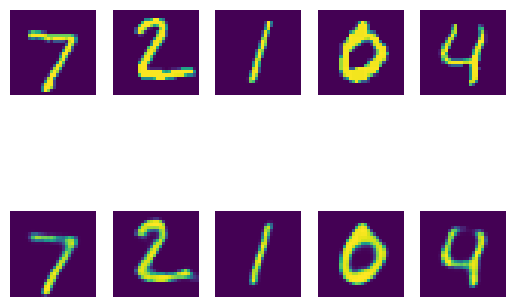

In [10]:
fig, axs = plt.subplots(2, 5) # 2행 5열로 출력
count = 0
for k in range(5):
  axs[0, k].imshow(X_test[count].reshape(28, 28))
  axs[0, k].axis('off')
  axs[1, k].imshow(ae_imgs[count].reshape(28, 28))
  axs[1, k].axis('off')
  count += 1
  fig.savefig(os.path.join(save_path, "MNIST_AE/")+"ae_mninst.png")